# Mean-field for triangular lattice

In [22]:
%matplotlib inline

import time
import pickle

import numpy as np
import numpy.linalg as la
from scipy.optimize import brentq, minimize_scalar
import matplotlib.pyplot as plt

## Define the lattice

In [23]:
t = 1.0
tp1 = 0.
tp2 = 0.
tperp = 0.
Lx, Ly, Lz = 16, 16, 1

# dispersion and k-mesh
epsk = lambda kx, ky, kz: - 2 * t * (np.cos(kx) + np.cos(ky)) \
                          - 2 * tp1 * np.cos(kx + ky)         \
                          - 2 * tp2 * np.cos(kx - ky)         \
                          - 2 * tperp * np.cos(kz)

kxr = np.linspace(-np.pi, np.pi, Lx, endpoint=False)
kyr = np.linspace(-np.pi, np.pi, Ly, endpoint=False)
kzr = np.linspace(-np.pi, np.pi, Lz, endpoint=False)
kx, ky, kz = np.meshgrid(kxr,kyr,kzr)

Qx, Qy, Qz = 0.,0.,0.

## Mean-field equations

In [24]:
# fermi function
def fermi(eps, beta):
    return 1 / (1 + np.exp(beta * eps))

# derivative of fermi function
def dfermi(eps, beta):
    return -beta / (2 * np.cosh(beta*eps) + 2)

def n_and_slope(mup, nn, mm):
    """Returns the density and the slope of the magnetization"""
    Ep = epsk(kx+Qx/2, ky+Qy/2, kz+Qz/2)
    Em = epsk(kx-Qx/2, ky-Qy/2, kz-Qz/2)
    Ek = 0.5 * (Ep + Em)
    etak = 0.5 * (Ep - Em)
    delta = U * mm / 2 

    E_plus  = Ek + U * nn / 2 - mup + np.sqrt(etak**2 + delta**2)
    E_minus = Ek + U * nn / 2 - mup - np.sqrt(etak**2 + delta**2)

    # treatment to avoid divisions by zero
    M = np.zeros_like(kx)
    delta_E = E_plus - E_minus
    mask = np.abs(E_plus - E_minus) > 1e-10
    delta_E[~mask] = np.nan
    M[mask] = ((fermi(E_minus, beta) - fermi(E_plus, beta)) / delta_E)[mask]
    M[~mask] = (-dfermi(E_plus, beta))[~mask]
    
    n = np.sum(fermi(E_plus, beta) + fermi(E_minus, beta))
    slope = U * np.sum(M)
    n /= Lx*Ly*Lz
    slope /= Lx*Ly*Lz
    return [n, slope]

def solve_for_n(mu, m):
    """Returns n and the slope"""
    n = brentq(lambda n1: n_and_slope(mu, n1, m)[0] - n1, 0, 2)
    return n_and_slope(mu, n, m)

def solve_for_mu(density, m):
    """Returns mu, n and the slope"""
    mu = brentq(lambda mu1: solve_for_n(mu1, m)[0] - density, -5*U, 5*U)
    return [mu] + solve_for_n(mu, m)

def solve_mean_field(density):
    """Returns the density, the magnetization and the chemical potential"""
    mu, n, slope = solve_for_mu(density, 0.0)
    if slope < 1: return n, 0.0, mu
        
    m = brentq(lambda m1: solve_for_mu(density, m1)[2] - 1, 0., 1.)
    mu, n, slope = solve_for_mu(density, m)
    return n, slope*m, mu

def compute_free_energy(g_or_h, n, m, mu):
    Ep = epsk(kx+Qx/2, ky+Qy/2, kz+Qz/2)
    Em = epsk(kx-Qx/2, ky-Qy/2, kz-Qz/2)
    Ek = 0.5 * (Ep + Em)
    etak = 0.5 * (Ep - Em)
    delta = U * m / 2 

    E_plus  = Ek + U * n / 2 - mu + np.sqrt(etak**2 + delta**2)
    E_minus = Ek + U * n / 2 - mu - np.sqrt(etak**2 + delta**2)
    
    # log Z term
    logZ =  - np.sum(np.log(np.ones(kx.shape) + np.exp(-beta*E_plus)))/beta   \
        - np.sum(np.log(np.ones(kx.shape) + np.exp(-beta*E_minus)))/beta
    
    # free energy
    if g_or_h == "Helmholtz":
        F = logZ / (Lx*Ly*Lz) + mu * n - 0.25 * U * (n-m) * (n+m)
    elif g_or_h == "Gibbs":
        F = logZ / (Lx*Ly*Lz) - 0.25 * U * (n-m) * (n+m)
    else:
        return np.nan
    
    return F

In [25]:
U = 8
beta = 1/.2
π = np.pi
import time
start = (time.time())
for q in np.linspace(0,π,10):
    Qx, Qy, Qz = q,q,q
    for beta in [2,5,10,20]:
        compute_free_energy("Helmholtz",0.8,0.8,U/2)
print((time.time() - start)/40)

0.0


0
1
2
3
4
5


<ipython-input-24-846ab3a00e85>:3: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(beta * eps))
<ipython-input-24-846ab3a00e85>:7: RuntimeWarning: overflow encountered in cosh
  return -beta / (2 * np.cosh(beta*eps) + 2)


6


<ipython-input-24-846ab3a00e85>:7: RuntimeWarning: overflow encountered in multiply
  return -beta / (2 * np.cosh(beta*eps) + 2)


7
8
9



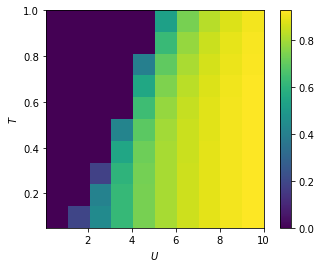

In [27]:
# The magnetization as a function of (U,T)

eps = 1e-5

npoint = 10
U_l = np.linspace(0.1, 10, npoint)
T_l = np.linspace(0.05, 1, npoint)

Qx, Qy, Qz = np.pi, np.pi, 0

MMat = np.zeros((len(U_l), len(T_l)))

for j, U in enumerate(U_l):
    print(j)
    for i, T in enumerate(T_l):
        beta = 1/T
        n, m, mu = solve_mean_field(1)
        MMat[i,j] = m

extent = [U_l[0], U_l[-1], T_l[0], T_l[-1]]
aspect = (U_l[-1] - U_l[0]) / (T_l[-1] - T_l[0])
plt.imshow(MMat, extent = extent, aspect = aspect, origin = 'lower')
plt.colorbar()

plt.xlabel('$U$')
plt.ylabel('$T$')
print()

## Free energy versus interaction

This is an attempt to reproduce the results from the paper
*Mean-field solution of the Hubbard model: the magnetic phase diagram*, by
Y. Claveau, B. Arnaud and S. Di Matteo, `arXiv:1403.2259`, March 2014.

We compute the Free energy as a function of the interaction at fixed density. The relevant
thermodynamics potential is then the Helmholtz free energy $F = U - TS$.

In [5]:
#%%timeit

# Find AF and FM free energy
beta = 20
n_target = 0.8

precision = 20
t_on_U = np.linspace(0.10, 0.25, precision)

# Para
n_pa = np.zeros(precision)
mu_pa = np.zeros(precision)
free_pa = np.zeros(precision)

Qx, Qy, Qz = 0., 0., 0.

for i in range(precision):
    U = t/t_on_U[i]
    mu, n, slope = solve_for_mu(n_target, 0.0) # impose m=0
    n_pa[i] = n
    mu_pa[i] = mu
    free_pa[i] = compute_free_energy('Helmholtz', n, 0.0, mu)

# FM
n_fm = np.zeros(precision)
mag_fm = np.zeros(precision)
mu_fm = np.zeros(precision)
free_fm = np.zeros(precision)

Qx, Qy, Qz = 0., 0., 0.
for i in range(precision):
    U = t/t_on_U[i]
    n, m, mu = solve_mean_field(n_target)
    n_fm[i] = n
    mag_fm[i] = m
    mu_fm[i] = mu
    free_fm[i] = compute_free_energy('Helmholtz', n, m, mu)

# AF
n_af = np.zeros(precision)
mag_af = np.zeros(precision)
mu_af = np.zeros(precision)
free_af = np.zeros(precision)

Qx, Qy, Qz = np.pi, np.pi, 0.
for i in range(precision):
    U = t/t_on_U[i]
    n, m, mu = solve_mean_field(n_target)
    n_af[i] = n
    mag_af[i] = m
    mu_af[i] = mu
    free_af[i] = compute_free_energy('Helmholtz', n, m, mu)

<ipython-input-3-846ab3a00e85>:3: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(beta * eps))
<ipython-input-3-846ab3a00e85>:7: RuntimeWarning: overflow encountered in cosh
  return -beta / (2 * np.cosh(beta*eps) + 2)
<ipython-input-3-846ab3a00e85>:7: RuntimeWarning: overflow encountered in multiply
  return -beta / (2 * np.cosh(beta*eps) + 2)


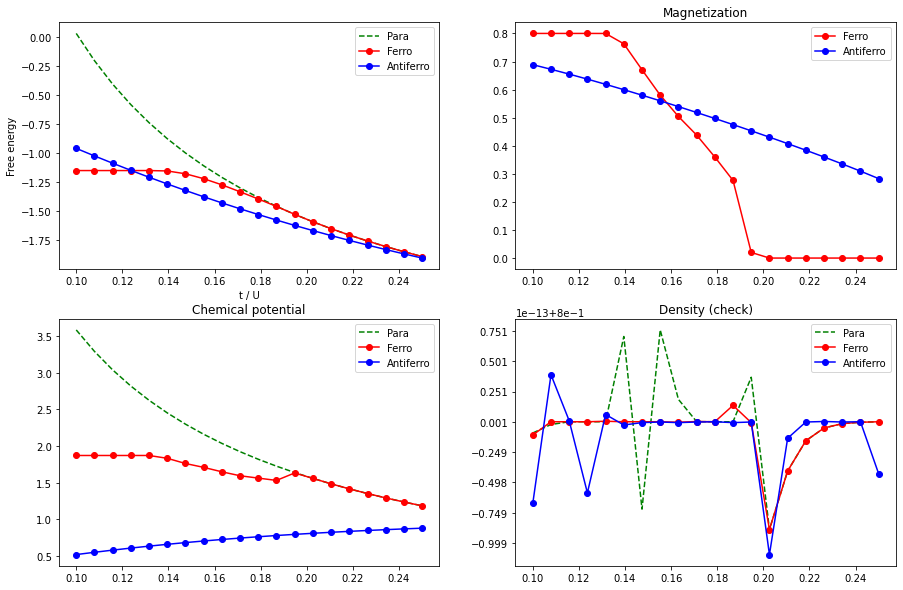

In [15]:
plt.figure(figsize=[15,10])
# Free energies
plt.subplot(221)
plt.plot(t_on_U, 2*free_pa, 'g--', label="Para")
plt.plot(t_on_U, 2*free_fm, 'ro-', label="Ferro")
plt.plot(t_on_U, 2*free_af, 'bo-', label="Antiferro")
#plt.title("Free energies")

plt.xlabel("t / U");
plt.ylabel("Free energy")
plt.legend()

# Magnetization
plt.subplot(222)
plt.plot(t_on_U, mag_fm, 'ro-', label="Ferro")
plt.plot(t_on_U, mag_af, 'bo-', label="Antiferro")
plt.title("Magnetization")
plt.legend()

# Chemical potential
plt.subplot(223)
plt.plot(t_on_U, mu_pa, 'g--', label="Para")
plt.plot(t_on_U, mu_fm, 'ro-', label="Ferro")
plt.plot(t_on_U, mu_af, 'bo-', label="Antiferro")
plt.title("Chemical potential")
plt.legend()

# Density (check)
plt.subplot(224)
plt.plot(t_on_U, n_pa, 'g--', label="Para")
plt.plot(t_on_U, n_fm, 'ro-', label="Ferro")
plt.plot(t_on_U, n_af, 'bo-', label="Antiferro")
plt.title("Density (check)")
plt.legend()


## Phase separation in Hubbard model

This is an attempt to reproduce some of the results of the paper
_Mean Field Magnetic Phase Diagrams for the Two
Dimensional t − t − U Hubbard Model_ by
Edwin Langmann and Mats Wallin,
Journal of Statistical Physics, Vol. 127, No. 4, May 2007.

We only compare three solutions: paramagnetic, ferromagnetic and antiferromagnetic

### As a function of density

In [6]:
# Find AF and FM free energy
beta = 100
U = 4.0
nr = np.linspace(.5, 1, 20)

# Para
n_pm = np.zeros_like(nr)
mu_pm = np.zeros_like(nr)
free_pm = np.zeros_like(nr)

Qx, Qy, Qz = 0., 0., 0.
for i, n_target in enumerate(nr):
    mu, n, slope = solve_for_mu(n_target, 0.0) # impose m=0
    n_pm[i] = n
    mu_pm[i] = mu
    free_pm[i] = compute_free_energy('Helmholtz', n, 0.0, mu)


# FM
n_fm = np.zeros_like(nr)
mag_fm = np.zeros_like(nr)
mu_fm = np.zeros_like(nr)
free_fm = np.zeros_like(nr)

Qx, Qy, Qz = 0., 0., 0.
for i, n_target in enumerate(nr):
    n, m, mu = solve_mean_field(n_target)
    n_fm[i] = n
    mag_fm[i] = m
    mu_fm[i] = mu
    free_fm[i] = compute_free_energy('Helmholtz', n, m, mu)

# AF
n_af = np.zeros_like(nr)
mag_af = np.zeros_like(nr)
mu_af = np.zeros_like(nr)
free_af = np.zeros_like(nr)

Qx, Qy, Qz = np.pi, np.pi, 0.
for i, n_target in enumerate(nr):
    n, m, mu = solve_mean_field(n_target)
    n_af[i] = n
    mag_af[i] = m
    mu_af[i] = mu
    free_af[i] = compute_free_energy('Helmholtz', n, m, mu)

<ipython-input-3-846ab3a00e85>:3: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(beta * eps))
<ipython-input-3-846ab3a00e85>:7: RuntimeWarning: overflow encountered in cosh
  return -beta / (2 * np.cosh(beta*eps) + 2)
<ipython-input-3-846ab3a00e85>:7: RuntimeWarning: overflow encountered in multiply
  return -beta / (2 * np.cosh(beta*eps) + 2)


In [7]:
free_pm1 = free_pm
free_af1 = free_af
mag_af1 = mag_af

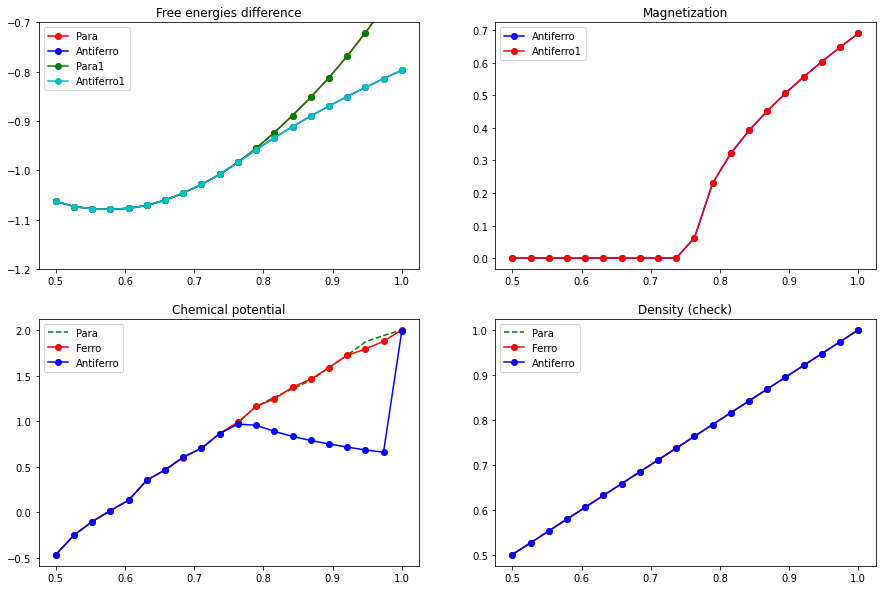

In [8]:
plt.figure(figsize=[15,10])
# Free energies
plt.subplot(221)
plt.plot(nr, free_pm, 'ro-', label="Para")
plt.plot(nr, free_af, 'bo-', label="Antiferro")
plt.plot(nr, free_pm1, 'go-', label="Para1")
plt.plot(nr, free_af1, 'co-', label="Antiferro1")
plt.title("Free energies difference")
plt.legend()
plt.ylim(-1.2,-0.7)

# Magnetization
plt.subplot(222)
#plt.plot(nr, mag_fm, 'ro-', label="Ferro")
plt.plot(nr, mag_af, 'bo-', label="Antiferro")
plt.plot(nr, mag_af1, 'ro-', label="Antiferro1")
plt.title("Magnetization")
plt.legend()

# Chemical potential
plt.subplot(223)
plt.plot(nr, mu_pm, 'g--', label="Para")
plt.plot(nr, mu_fm, 'ro-', label="Ferro")
plt.plot(nr, mu_af, 'bo-', label="Antiferro")
plt.title("Chemical potential")
plt.legend()

# Density (check)
plt.subplot(224)
plt.plot(nr, n_pm, 'g--', label="Para")
plt.plot(nr, n_fm, 'ro-', label="Ferro")
plt.plot(nr, n_af, 'bo-', label="Antiferro")
plt.title("Density (check)")
plt.legend()

### Inspect free energy versus m

This is to decide whether there is phase separation

In [9]:
# Find AF and FM free energy
n_target = 0.75

mr = np.linspace(0,1,10)

f_fe = np.zeros_like(mr)
Qx, Qy, Qz = 0., 0., 0.
for i,m in enumerate(mr):
    mu, n, slope = solve_for_mu(n_target, m)
    f_fe[i] = compute_free_energy('Helmholtz', n, m, mu)
n, m, mu = solve_mean_field(n_target)
print('fe: ', n, m, mu-0.5*U)
print(compute_free_energy('Helmholtz', n, m, mu))


f_af = np.zeros_like(mr)
Qx, Qy, Qz = np.pi, np.pi, 0.
for i,m in enumerate(mr):
    mu, n, slope = solve_for_mu(n_target, m)
    f_af[i] = compute_free_energy('Helmholtz', n, m, mu)
n, m, mu = solve_mean_field(n_target)
print('af: ', n, m, mu-U*0.5)
print(compute_free_energy('Helmholtz', n, m, mu))

<ipython-input-3-846ab3a00e85>:3: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(beta * eps))
<ipython-input-3-846ab3a00e85>:7: RuntimeWarning: overflow encountered in cosh
  return -beta / (2 * np.cosh(beta*eps) + 2)
<ipython-input-3-846ab3a00e85>:7: RuntimeWarning: overflow encountered in multiply
  return -beta / (2 * np.cosh(beta*eps) + 2)


fe:  0.750000000000011 0.00938813896933749 -1.0685729697622544
-0.9960438194208572
af:  0.7499999999999998 0.0 -1.0629294758701269
-0.9960380920529508


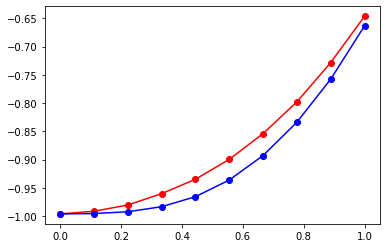

In [10]:
plt.plot(mr, f_fe, 'ro-')
plt.plot(mr, f_af, 'bo-')

## (T,n) Phase diagrams

Below is an attempt to construct (T,n) phase diagrams for a square lattice, at various U, and investigating different Q vectors along a high-symmetry path.

### Parameters
The range of U, T, n and the Q_vectors to analyze, and the parameters of the lattice.

In [8]:
#Possible magnetizations
Qx_r = np.linspace(0, np.pi, 10)
Qy_r = np.linspace(0, np.pi, 10)
Qz = 0.

#Along Ox, (np.pi,Oy) and the first bissectrix
#Q_vectors = [(qx,0.) for qx in Qx_r] + [(np.pi,qy) for qy in Qy_r] + [(qx,qx) for qx in Qx_r]
#(q,π) and AF
Q_vectors = [(0,0)] + [(qx,np.pi) for qx in Qx_r]

#Range of values to investigate

n_min, n_max, n_number = 0.01, 1, 100
nr = np.linspace(n_min, n_max, n_number)

T_min, T_max, T_number = 0.01, 1, 100
Tr = np.linspace(T_min, T_max, T_number)

U_min, U_max, U_step = 2, 12, 2
Ur = np.array([10])

#square lattice
tp1, tp2 = 0.,0.

### Computation of the free energy and magnetisation for each Q vector in the parameter space

In [ ]:
#The energy of a given set of parameters is dict[U,n,T][ Q_vector ]
#Q_vector is "para" for a paramagnetic state, and (Qx,Qy) for magnetized states.
f_energy_dict = dict()
mag_dict = dict()

#Progression indicators
parameter_space_volume = len(Ur)*len(nr)*len(Tr)
current_volume = 0

start = int(time.time())
progress_indicator = [(start, 0.)]

for U in Ur:
    for n in nr:
        for T in Tr:
            beta = 1/T
            
            f_energy_dict[U,n,T] = dict()
            mag_dict[U,n,T] = dict()

            #test paramagnetic case first
            Qx, Qy, Qz = 0.,0.,0.
            mu, n_res, slope = solve_for_mu(n, 0.0) # impose m=0
            f_energy_dict[U,n,T]["para"] = compute_free_energy('Helmholtz', n_res, 0.0, mu)
            
            #Then investigate Q vectors
            for Qx, Qy in Q_vectors:
                n_res, m, mu = solve_mean_field(n)
                f_energy_dict[U,n,T][(Qx,Qy)] = compute_free_energy('Helmholtz', n_res, m, mu)
                mag_dict[U,n,T][(Qx,Qy)] = m
        
            #Keep track of progress
            current_volume += len(Tr)
            progress_indicator.append((int(time.time())-start, 100*current_volume/parameter_space_volume))
            print("{:.2f}s since computation started.".format(progress_indicator[-1][0]))
            print("{:.2f}% of parameter space explored.".format(progress_indicator[-1][1]))
                

### Optimization of the Q vector

In [ ]:
#To get a result: res_dict(n,T,"energy","piq")] --> float
#Third key: "energy", "mag", "mu", "Q"
#Fourth key: "para", "q0", "piq", "qq"
res_dict = dict()


#Functions that will be otptimized to get a  minimal energy Q vector

#Q along Ox
def opti_q0(q):
    global Qx, Qy, Qz
    Qx, Qy, Qz = q, 0., 0.
    n_res, m, mu = solve_mean_field(n)
    return (m != 0.)*compute_free_energy('Helmholtz', n_res, m, mu)

#Q along (π,y)
def opti_piq(q):
    global Qx, Qy, Qz
    Qx, Qy, Qz = np.pi, q, 0.

    n_res, m, mu = solve_mean_field(n)
    
    return (m != 0.)*compute_free_energy('Helmholtz', n_res, m, mu)

#Q along first bissectrix
def opti_qq(q):
    global Qx, Qy, Qz
    Qx, Qy, Qz = q, q, 0.
    n_res, m, mu = solve_mean_field(n)
    return (m != 0.)*compute_free_energy('Helmholtz', n_res, m, mu)

#Progression indicators
parameter_space_volume = len(nr)*len(Tr)
current_volume = 0

start = int(time.time())
progress_indicator = [(0., 0.)]

U = Ur[0]
for n in nr:
    for T in Tr:
        beta = 1/T

        #Compute paramagnetic case first
        Qx, Qy, Qz = 0.,0.,0.
        mu, n_res, slope = solve_for_mu(n, 0.0) # impose m=0
        
        res_dict[n,T,"energy","para"] = compute_free_energy('Helmholtz', n_res, 0.0, mu)
        res_dict[n,T,"mag","para"] = 0
        res_dict[n,T,"mu","para"] = mu
        res_dict[n,T,"Q","para"] = 0

        #Then investigate Q vectors
        #(q,0)
        q = minimize_scalar(opti_q0, bounds=(0, np.pi), method='bounded').x
        Qx, Qy, Qz = q, 0., 0.
        n_res, m, mu = solve_mean_field(n)
        
        res_dict[n,T,"energy","q0"] = compute_free_energy('Helmholtz', n_res, m, mu)
        res_dict[n,T,"mag","q0"] = m
        res_dict[n,T,"mu","q0"] = mu
        res_dict[n,T,"Q","q0"] = q

        #(π,q)
        q = minimize_scalar(opti_piq, bounds=(0, np.pi), method='bounded').x
        Qx, Qy, Qz = np.pi, q, 0.
        n_res, m, mu = solve_mean_field(n)
        
        res_dict[n,T,"energy","piq"] = compute_free_energy('Helmholtz', n_res, m, mu)
        res_dict[n,T,"mag","piq"] = m
        res_dict[n,T,"mu","piq"] = mu
        res_dict[n,T,"Q","piq"] = q

        #(q,q)
        q = minimize_scalar(opti_qq, bounds=(0, np.pi), method='bounded').x
        Qx, Qy, Qz = q, q, 0.
        n_res, m, mu = solve_mean_field(n)
        
        res_dict[n,T,"energy","qq"] = compute_free_energy('Helmholtz', n_res, m, mu)
        res_dict[n,T,"mag","qq"] = m
        res_dict[n,T,"mu","qq"] = mu
        res_dict[n,T,"Q","qq"] = q

    #Keep track of progress
    current_volume += T_number
    progress_indicator.append((int(time.time())-start, 100*current_volume/parameter_space_volume))
    #print("{:.2f}s since computation started.".format(progress_indicator[-1][0]))
    print("{:.2f}% of parameter space explored.".format(progress_indicator[-1][1]))

    current_speed = (progress_indicator[-1][-1] - progress_indicator[-2][-1]) \
                    / (progress_indicator[-1][0] - progress_indicator[-2][0])
    linear_pred = (100 - progress_indicator[-1][1])/current_speed/3600
    print("{:.0f}h{:.0f}min until completion.".format(linear_pred, 60*(linear_pred - int(linear_pred))))

In [ ]:
#Plot of time taken

times = [progress_indicator[i][0]/3600 for i in range(101)]
percent = [i for i in range(101)]

speed = [ (percent[i+1] - percent[i])/(times[i+1] - times[i]) for i in range(100)]


plt.plot(times[:-1], speed, "-o")

plt.xlabel("t(h)")
plt.ylabel("%/h")

plt.show()

### Computation of the Q_vector with lowest energy

In [ ]:
#The dictionnary below contains the phase with the least energy. It is either "para" or a tuple (Qx, Qy)
#If the phase with least energy should be magnetized but has magnetization 0, "para" is chosen instead
phase_dict = dict()
for params in f_energy_dict:
    less_energetic = min(f_energy_dict[params], key = f_energy_dict[params].get)
    phase_dict[params] = less_energetic if less_energetic == "para" or abs(mag_dict[params][less_energetic]) > 1e-3 else "para"

In [23]:
#The dictionnary below contains the phase with the least energy. It is either "para" or a tuple (Qx, Qy)
#If the phase with least energy should be magnetized but has magnetization 0, "para" is chosen instead
phase_dict = dict()
mag_dict = dict()
phase_type = ["para", "q0", "piq", "qq"]

for n in nr:
    for T in Tr:
        
        #Determine if the q vector with lowest energy is para, q0, piq or qq
        e_dico = {phase: res_dict[n,T, "energy", phase] for phase in phase_type}
        potential_phase = min(e_dico, key = e_dico.get)
        
        q = res_dict[n,T, "Q", potential_phase]
        mag = res_dict[n,T, "mag", potential_phase]
        
        if potential_phase == "para":
            phase_dict[n,T] = "PM"
            mag_dict[n,T] = 0
            
        #No magnetisation means it's paramagnetic
        elif mag == 0.:
            phase_dict[n,T] = "PM"
            mag_dict[n,T] = 0
            
        #Q = (0,0) --> FM
        elif potential_phase in ["q0", "qq"] and abs(q) < 1e-3:
            phase_dict[n,T] = "FM"
            mag_dict[n,T] = res_dict[n,T,"mag", potential_phase]
        
        #Q = (π,π) --> AF
        elif potential_phase in ["piq", "qq"] and abs(q - np.pi) < 1e-5:
            phase_dict[n,T] = "AF"
            mag_dict[n,T] = res_dict[n,T,"mag", potential_phase]
        
        #Register the non particular Q vector
        else:
            if potential_phase == "q0":
                q_vect = (q,0.)
            elif potential_phase == "piq":
                q_vect = (np.pi, q)
            elif potential_phase == "qq":
                q_vect = (q,q)
            else:
                raise RuntimeError("I fucked up completely.")
            
            phase_dict[n,T] = q_vect
            mag_dict[n,T] = res_dict[n,T,"mag", potential_phase]

#print(len([1 for val in phase_dict.values() if val == "PM"]))

## Phase diagram plot

### Colored phase

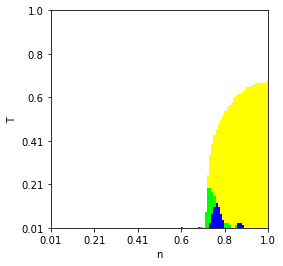

In [25]:
#Some definitions to help the following
U_aff = 4
n_to_index = {nr[i]:i for i in range(len(nr))}
T_to_index = {Tr[i]:i for i in range(len(Tr))}


#Options
magnetisation_only = False
separate_q_type = True
magnetisation_transparency = False


#Create and plot diagram
diagram = np.zeros((len(Tr), len(nr),3 if magnetisation_only else 4))



for key in phase_dict:
    ni = n_to_index[key[0]]
    Ti = T_to_index[key[1]]
    
    if magnetisation_only:
        diagram[Ti,ni, 0] = 1 - mag_dict[key]
        diagram[Ti,ni, 1] = 1 - mag_dict[key]
        diagram[Ti,ni, 2] = 1 - mag_dict[key]
        continue

    
    if phase_dict[key] == "PM":
        diagram[Ti,ni, 0] = 1
        diagram[Ti,ni, 1] = 1
        diagram[Ti,ni, 2] = 1
        diagram[Ti,ni, 3] = 1
        
    elif phase_dict[key] == "FM":
        diagram[Ti,ni, 0] = 0
        diagram[Ti,ni, 1] = 0
        diagram[Ti,ni, 2] = 0
        diagram[Ti,ni, 3] = 1
        
    elif phase_dict[key] == "AF":
        diagram[Ti,ni, 0] = 1
        diagram[Ti,ni, 1] = 1
        diagram[Ti,ni, 2] = 0
        diagram[Ti,ni, 3] = mag_dict[key] if magnetisation_transparency else 1
    
    else:
        if phase_dict[key][1] == 0:
            diagram[Ti,ni, 0] = 1
            diagram[Ti,ni, 1] = 0
            diagram[Ti,ni, 2] = 0
            
        elif abs(phase_dict[key][0] - np.pi) < 1e-3:
            diagram[Ti,ni, 0] = 0
            diagram[Ti,ni, 1] = 1
            diagram[Ti,ni, 2] = 0
        else:
            diagram[Ti,ni, 0] = 0
            diagram[Ti,ni, 1] = 0
            diagram[Ti,ni, 2] = 1
            
            
        diagram[Ti,ni, 3] = mag_dict[key] if magnetisation_transparency else 1
        
        if not separate_q_type:
            diagram[Ti,ni, 0] = phase_dict[key][0]/np.pi
            diagram[Ti,ni, 1] = phase_dict[key][1]/np.pi
            diagram[Ti,ni, 2] = 0


#Display in the correct orientation
plt.imshow(diagram, origin = "lower", interpolation = "none")

#Display the correct axes
locs, labels = plt.xticks()
labels = [np.round(n_min + (n_max-n_min)*item/locs[-1],2) for item in locs]
labels[0] = ""
plt.xticks(locs, labels)

locs, labels = plt.yticks()
labels = [np.round(T_min + (T_max-T_min)*item/locs[-1],2) for item in locs]
labels[0] = ""
plt.yticks(locs, labels)

plt.xlabel("n")
plt.ylabel("T")

#TODO: beer
plt.xlim(0,n_number)
plt.ylim(0,T_number)

plt.show()



In [21]:
for key in phase_dict:
    if phase_dict[key] != 'PM':
        print("Not PM: ", key)

Not PM:  (0.8400000000000001, 0.01)
Not PM:  (0.9, 0.01)
Not PM:  (0.97, 0.01)


In [ ]:
#plt.plot(nr, [res_dict[n, 0.01, "energy", "q0"] for n in nr], "or-", label="0q")
#plt.plot(nr, [res_dict[n, 0.01, "energy", "piq"] for n in nr],"og-", label="piq")
#plt.plot(nr, [res_dict[n, 0.01, "energy", "qq"] for n in nr], "ob-",label="qq")

plt.plot(nr, [res_dict[n, 0.01, "energy", "piq"]/res_dict[n, 0.01, "energy", "qq"] for n in nr], "ob-",label="64")
plt.plot(nr, the_save_128, "or-",label="128")

plt.xlabel("n")
plt.ylabel("E_piq/E_qq")

plt.xlim(0.9,1)
plt.ylim(0.9997,1.0005)

plt.legend()
plt.show()

#print([n for n in nr if res_dict[n, 0.01, "energy", "piq"] > res_dict[n, 0.01, "energy", "qq"]])

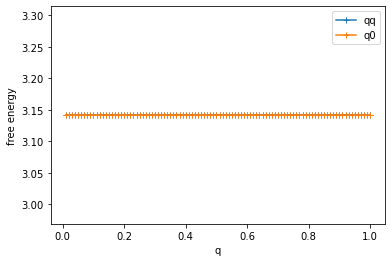

In [27]:
#plt.plot(nr, [res_dict[n,0.2,"energy","piq"] for n in nr], '+-', label="piq")
plt.plot(nr, [res_dict[n,0.2,"Q","qq"] for n in nr], '+-', label="qq")
plt.plot(nr, [res_dict[n,0.2,"Q","q0"] for n in nr], '+-', label="q0")
#plt.plot(nr, [res_dict[n,0.2,"energy","para"] for n in nr], '+-', label="para")


plt.xlabel("q")
plt.ylabel("free energy")
plt.legend()
plt.draw()

### Saving and loading results
(because the computation takes quite a long time)

In [ ]:
#with open("nT_hundred_grid_u.pickle", "wb") as phase_file:
#    pickle.dump(res_dict, phase_file)

res_dict_save = dict(res_dict)

In [22]:
with open("nT_grid_diag_u4.pickle", 'rb') as input:
    res_dict = pickle.load(input)
#print(energy_dict)

In [2]:
with open("Q_grid_n_0_85.pickle", 'rb') as input:
    Q_grid = pickle.load(input)

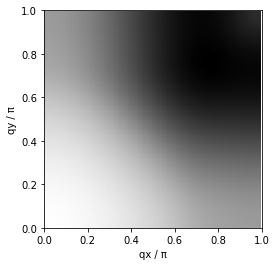

In [3]:
aff = np.zeros((100,100,3))
aff[:,:,0] = (Q_grid - np.min(Q_grid))/np.max(Q_grid - np.min(Q_grid))
aff[:,:,1] = (Q_grid - np.min(Q_grid))/np.max(Q_grid - np.min(Q_grid))
aff[:,:,2] = (Q_grid - np.min(Q_grid))/np.max(Q_grid - np.min(Q_grid))

plt.imshow(aff,origin="lower",interpolation="none")

locs, labels = plt.xticks()
labels = [np.round(item/locs[-1],2) for item in locs]
labels[0] = ""
plt.xticks(locs, labels)

locs, labels = plt.yticks()
labels = [np.round(item/locs[-1],2) for item in locs]
labels[0] = ""
plt.yticks(locs, labels)

plt.xlim([0,100])
plt.xlabel("qx / π")
plt.ylim([0,100])
plt.ylabel("qy / π")

plt.show()

In [6]:
np.unravel_index(np.argmin(Q_grid, axis=None), Q_grid.shape)


0.7676767676767677

Objectifs: 
2D square: U={2,4,6,8,10,12}

2D square: 64x64 low temperatures

3D cubic: U={2,4,6,8,10,12} L=20x20x20

(0,0,q) - (0,q,q) - (q,q,q) - (pi,q,q) - (pi,pi,q) - (0,pi,q) 

2D square t'=0.3

0<n<2

## F on path

In [4]:
import os
os.getcwd()

'/Users/LiamRampon/Documents/Éducation/ENSTA/3A/PRL'

In [7]:
π = np.pi

U, n, T = 8.0, 0.2, 0.6
beta = 1/T

q_res = 19
dq = np.pi/(q_res+1)
q_min = dq
q_max = np.pi-dq


F = np.zeros((6, q_res+2))
mag = np.zeros((6, q_res+2))
mu = np.zeros((6, q_res+2))
dens = np.zeros((6, q_res+2))


for side_idx, side in enumerate(["00q", "0qq", "qqq", "0qπ", "qqπ", "qππ"]):
    print(f"Computing side {side}...")
    for q_idx, q in enumerate(np.linspace(q_min, q_max, q_res)):
        #Initialize Q
        side_conv = {"0":0, "q":q, "π":np.pi}
        Qx, Qy, Qz = side_conv[side[0]], side_conv[side[1]], side_conv[side[2]]
        
        #Compute MF solution
        n_res, m_res, mu_res = solve_mean_field(n)
        F_res = compute_free_energy('Helmholtz', n_res, m_res, mu_res)

        #PM case
        #mu_para, n_res_para, slope_para = solve_for_mu(n, 0.0) # impose m=0
        #F_para = compute_free_energy("Helmholtz", n_res_para, 0, mu_para)
        
        #Add it to results
        F[side_idx, q_idx +1] = F_res
        mag[side_idx, q_idx +1] = m_res
        mu[side_idx, q_idx +1] = mu_res
        dens[side_idx, q_idx +1] = n_res

        
for vertex in ['Γ', 'X', 'M', 'R']:

    print(f"Computing vertex {vertex}...")
    
    #Initialize Q
    if vertex == 'Γ':
        Qx, Qy, Qz = 0, 0, 0
    elif vertex == 'X':
        Qx, Qy, Qz = 0, 0, np.pi
    elif vertex == 'M':
        Qx, Qy, Qz = 0, np.pi, np.pi
    elif vertex == 'R':
        Qx, Qy, Qz = np.pi, np.pi, np.pi


    #Compute MF solution
    n_vert, m_vert, mu_vert = solve_mean_field(n)
    F_vert = compute_free_energy('Helmholtz', n_vert, m_vert, mu_vert)


    #Add it to results
    if vertex == 'Γ':

        #Start of 00q, 0qq, qqq
        F[0:3,0] = F_vert
        mag[0:3,0] = m_vert
        mu[0:3,0] = mu_vert
        dens[0:3,0] = n_vert

    elif vertex == 'X':

        #Start of 0qπ, qqπ
        F[3:5,0] = F_vert
        mag[3:5,0] = m_vert
        mu[3:5,0] = mu_vert
        dens[3:5,0] = n_vert

        #End of 00q
        F[0,-1] = F_vert
        mag[0,-1] = m_vert
        mu[0,-1] = mu_vert
        dens[0,-1] = n_vert


    elif vertex == 'M':

        #Start of qππ
        F[5,0] = F_vert
        mag[5,0] = m_vert
        mu[5,0] = mu_vert
        dens[5,0] = n_vert

        #End of 0qq
        F[1,-1] = F_vert
        mag[1,-1] = m_vert
        mu[1,-1] = mu_vert
        dens[1,-1] = n_vert

        #End of 0qπ
        F[3,-1] = F_vert
        mag[3,-1] = m_vert
        mu[3,-1] = mu_vert
        dens[3,-1] = n_vert


    elif vertex == 'R':

        #End of qqq
        F[2,-1] = F_vert
        mag[2,-1] = m_vert
        mu[2,-1] = mu_vert
        dens[2,-1] = n_vert

        #End of qqπ, qππ
        F[4:,-1] = F_vert
        mag[4:,-1] = m_vert
        mu[4:,-1] = mu_vert
        dens[4:,-1] = n_vert
        
archive_name = f"U_{U:.1f}_n_{n:1.2f}_T_{T:.2f}_MF.pckl"
with open(f'/Users/LiamRampon/Downloads/diag_MF/{archive_name}', "wb") as f:
    pickle.dump((F, mag, mu, dens), f)
print(f"File saved as {archive_name}")

Computing side 00q...
Computing side 0qq...
Computing side qqq...
Computing side 0qπ...
Computing side qqπ...
Computing side qππ...
Computing vertex Γ...
Computing vertex X...
Computing vertex M...
Computing vertex R...
File saved as U_8.0_n_0.20_T_0.60_MF.pckl
